## 1. Requirement

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks import FastGradientMethod
from art.attacks import DeepFool
from art.attacks import SaliencyMapMethod
from art.attacks import ProjectedGradientDescent
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

## 2. Model

In [2]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # mnist의 경우 28*28의 흑백이미지(input channel=1)이다.
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding=2)
        # feature map의 크기는 14*14가 된다
        # 첫번재 convolution layer에서 나온 output channel이 32이므로 2번째 input도 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding=2)
        # feature map의 크기는 7*7이 된다
        # fc -> fully connected, fc는 모든 weight를 고려해서 만들기 때문에 cnn에서는 locally connected를 이용하여 만든다.
        # nn.Linear에서는 conv를 거친 feature map을 1차원으로 전부 바꿔서 input을 한다. 이게 64*7*7
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7) # linear에 들어갈 수 있도록 reshape
        x = F.relu(self.fc1(x)) # fully connected에 relu 적용
        x = F.dropout(x, training=self.training) # 가중치 감소만으로는 overfit을 해결하기가 어려움, 그래서 뉴런의 연결을 임의로 삭제
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## 3. Load MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

## 4. Load the models

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
if is_cuda: print("CUDA available!")
    
models = []

CUDA available!


In [5]:
model_path = './model/mnist_um_art.pth'
model = MnistModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
models.append(model)

print("model[0]: undefended model loaded")

model[0]: undefended model loaded


In [6]:
model_path = './model/mnist_fgsm_art.pth'
model = MnistModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
models.append(model)

print("model[1]: Linf trained model1 loaded")

model[1]: Linf trained model1 loaded


In [7]:
model_path = './model/mnist_pgd_art.pth'
model = MnistModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
models.append(model)

print("model[2]: Linf trained model2 loaded")

model[2]: Linf trained model2 loaded


In [8]:
model_path = './model/mnist_all_art.pth'
model = MnistModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
models.append(model)

print("model[3]: All trained model loaded")

model[3]: All trained model loaded


## 5. Create ART classifier

In [9]:
criterion = nn.CrossEntropyLoss()

# 0-um, 1-fgsm, 2-all
print('model #: 0-undefended, 1-fgsm, 2-pgd, 3-all')
classifiers = []
for model in models:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    classifier = PyTorchClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), loss=criterion,
                               optimizer=optimizer, input_shape=(1, 28, 28), nb_classes=10)
    classifiers.append(classifier)

print("classifiers created")

model #: 0-undefended, 1-fgsm, 2-all
classifiers created


## 6. Generate adversarial test examples

In [10]:
adv_tests = []
fgsm_trained = classifiers[1]

Linf1_attack = FastGradientMethod(classifier=fgsm_trained, eps=0.3)
Linf1_x_test_adv = Linf1_attack.generate(x=x_test)
adv_tests.append(Linf1_x_test_adv)

print('FGSM example generated')

FGSM example generated


## 7. Evaluate accuracy

In [17]:
models_accuracy = []
examples = []

print('model #: 0-um, 1-fgsm, 2-pgd, 3-all')
print('test  #: 0-fgsm: criterion-model[1]')

# test order: 0-fgsm
for i, (classifier) in enumerate(classifiers):
    print('\nmodel #{}'.format(i))
    model_accuracy = []
    example = []
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print('Accuracy on benign test examples: {}%'.format(accuracy * 100)) 
    model_accuracy.append(accuracy)
    b_ex = []
    for idx, (pred) in enumerate(predictions):
        if np.argmax(pred) != np.argmax(y_test[idx]):
            b_ex.append((x_test[idx], np.argmax(pred), np.argmax(y_test[idx])))
        if len(b_ex) == 5: 
            example.append(b_ex)
            break
        
    for j, (x_test_adv) in enumerate(adv_tests):
        adv_ex = []
        predictions = classifier.predict(x_test_adv)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print('Accuracy on model with adversarial test #{} examples: {}%'.format(j, accuracy * 100))
        model_accuracy.append(accuracy)
        for idx, (pred) in enumerate(predictions):
            if np.argmax(pred) != np.argmax(y_test[idx]):
                adv_ex.append((x_test_adv[idx], np.argmax(pred), np.argmax(y_test[idx])))
            if len(adv_ex) == 5: 
                example.append(adv_ex)
                break
    models_accuracy.append(model_accuracy)
    examples.append(example)

model #: 0-um, 1-fgsm, 2-pgd, 3-all
test  #: 0-fgsm: criterion-model[1]

model #0
Accuracy on benign test examples: 99.03999999999999%
Accuracy on model with adversarial test #0 examples: 76.52%

model #1
Accuracy on benign test examples: 88.96%
Accuracy on model with adversarial test #0 examples: 8.44%

model #2
Accuracy on benign test examples: 92.82000000000001%
Accuracy on model with adversarial test #0 examples: 17.52%

model #3
Accuracy on benign test examples: 98.83999999999999%
Accuracy on model with adversarial test #0 examples: 10.72%


## 8. Result

In [20]:
import pandas as pd
from pandas import DataFrame

data = {
    'clean': models_accuracy[0],
    'Linf1': models_accuracy[1],
    'Linf2': models_accuracy[2],
    'ALL': models_accuracy[3],
}

columns = ['clean', 'Linf1', 'Linf2', 'ALL']
idx = ['Benign', 'FGSM']
DataFrame(data, columns=columns, index=idx)

,clean,Linf1,Linf2,ALL
Benign,0.9904,0.8896,0.9282,0.9884
FGSM,0.7652,0.0844,0.1752,0.1072


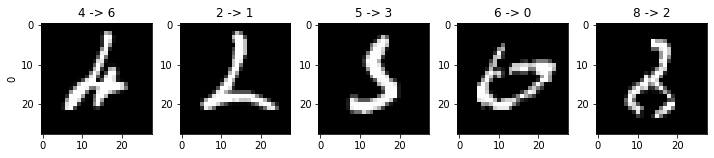

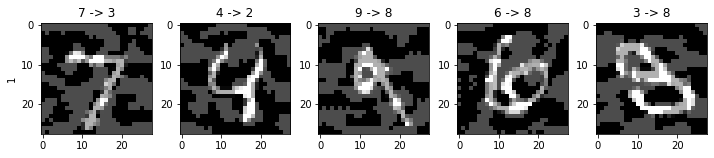

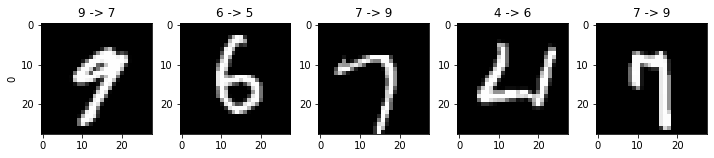

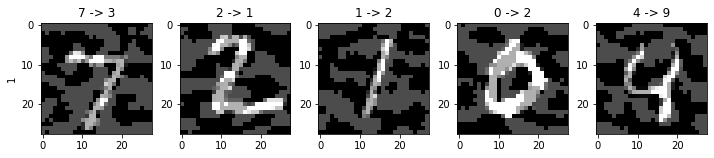

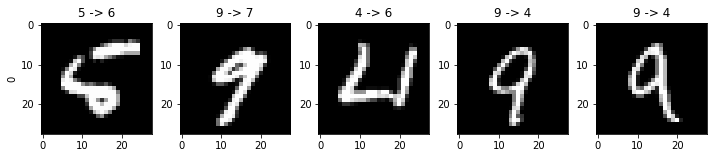

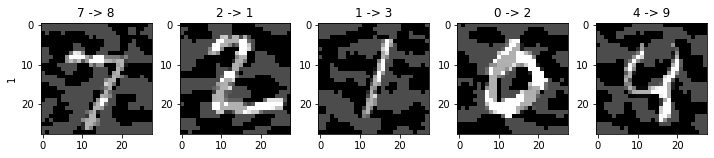

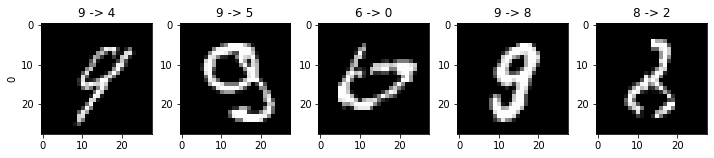

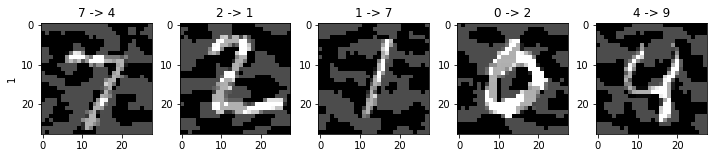

In [16]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
%matplotlib inline

SAVE_PATH = './examples/08/'


for i, (example) in enumerate(examples):
    for j, (images) in enumerate(example):    
        plt.figure(figsize=(10,10))
        cnt = 0
        for k, (image, pred, orig) in enumerate(images):
            cnt+=1
            plt.subplot(5, len(images), cnt)
            if k == 0:
                plt.ylabel(str(j))
            plt.title('{} -> {}'.format(orig, pred))
            plt.imshow(np.rot90(np.flip(image.reshape(28, 28, order='C'), axis=1)), cmap='gray')
            title = SAVE_PATH + str(i) +'_'+ str(j) + '_[' + str(orig) + '_' + str(pred) +'].png'
            save_image(torch.from_numpy(np.rot90(np.flip(image.reshape(28, 28, order='C'), axis=1))), title)
        plt.tight_layout()
        plt.show() 